<h1><center>FMH COPD Project</center></h1>

### Introduction
This project aims to discover the key care pathways for COPD. <br> The techniques used in this project includes regression, classification and association analysis.

### About the data set

Population (791 beneficiaries):<br>
- 2018_Q2 MSSP Assignment – Internally attributed to a MHP practice 
- 65 or older as of 8/1/2016
- Part A or Part B claim with COPD diagnosis code in date range 8/1/2016 – 7/31/2017

Flu Vaccine: Y/N<br>
- Between 8/1/2016 and 3/31/2017 <br>

Pneumococcal Vaccine: Y/N <br>
- Vaccination any time after beneficiary turned 65 

Medicare Annual Wellness Visit (AWV): Y/N <br>
- Between 8/1/2016 and 7/31/2017

Transitions of Care Management / Chronic Care Management (TCM/CCM): Y/N <br>
- Between 8/1/2016 and 7/31/2017

Inpatient Discharge (primary diagnosis of COPD): Count <br>
- Between 8/1/2016 and 7/31/2017

Inpatient Readmission: Count <br>
- Index visit between 8/1/2016 and 7/31/2017 
    - Reviewed claims until 8/31/2017 to identify July 2017 readmissions

Emergency Department Visit (primary diagnosis of COPD): Count
- Between 8/1/2016 and 7/31/2017



In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from matplotlib_venn import venn2
import matplotlib_venn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
import pydotplus
from sklearn.datasets import load_iris
import collections
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import re

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from scipy import stats

import matplotlib as mpl

In [4]:
fmh = pd.read_csv("COPD_Analysis_File_2.txt", index_col="pt_id")
del fmh.index.name

In [5]:
pd.set_option("display.max_rows", 1000)
fmh.head()

,Flu_Vac,Pneu_Vac,AWV,TCM_CCM,IP_DC_Count,Readmit_Count,ED_Visit_Count
1,1,1,0,0,1,0,1
2,1,1,0,0,0,0,0
3,1,1,0,0,0,0,0
4,1,1,0,0,0,0,0
5,1,1,0,0,0,0,0


*AWV & TCM_CCM will be combine together as "Preventive Care"*

In [6]:
fmh["Preventive_Care"] = fmh.AWV | fmh.TCM_CCM
fmh = fmh.drop(["AWV", "TCM_CCM"], axis=1)
cols = ["Flu_Vac", "Pneu_Vac", "Preventive_Care", "IP_DC_Count", "Readmit_Count", "ED_Visit_Count"]
fmh = fmh.ix[:, cols]

/home/cs52205/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [7]:
fmh.head()

,Flu_Vac,Pneu_Vac,Preventive_Care,IP_DC_Count,Readmit_Count,ED_Visit_Count
1,1,1,0,1,0,1
2,1,1,0,0,0,0
3,1,1,0,0,0,0
4,1,1,0,0,0,0
5,1,1,0,0,0,0


In [8]:
fmh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 1 to 791
Data columns (total 6 columns):
Flu_Vac            791 non-null int64
Pneu_Vac           791 non-null int64
Preventive_Care    791 non-null int64
IP_DC_Count        791 non-null int64
Readmit_Count      791 non-null int64
ED_Visit_Count     791 non-null int64
dtypes: int64(6)
memory usage: 43.3 KB


__Features__: Flu_Vac, Pneu_Vac, Preventive Care (NOTE: these are boolean)<br>
__Class labels__: IP_DC_Count, Readmit_Count, ED_Visit_Count (NOTE: these are __not__ boolean)

### Visualization of the basic information

In [9]:
#Turn into boolean, True = has inpatient
def make_bool(myseries, index_num):
    for index, value in myseries.iteritems():
        if value == 0:
            fmh.ix[index, index_num] = False
        else:
            fmh.ix[index, index_num] = True

#Turn into boolean, True means no in patient, no readmission, no emergency vist
def make_bool2(myseries, index_num):
    for index, value in myseries.iteritems():
        if value == 0:
            fmh.ix[index, index_num] = True
        else:
            fmh.ix[index, index_num] = False         

In [10]:
fmh["IP_DC"] = 0
make_bool(fmh["IP_DC_Count"], 6)
fmh["Readmit"] = 0
make_bool(fmh["Readmit_Count"], 7)
fmh["ED_Visit"] = 0
make_bool(fmh["ED_Visit_Count"], 8)
fmh["No_IP"] = 0
make_bool2(fmh["IP_DC_Count"], 9)
fmh["No_Readmit"] = 0
make_bool2(fmh["Readmit_Count"], 10)
fmh["No_ED"] = 0
make_bool2(fmh["ED_Visit_Count"], 11)

/home/cs52205/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/home/cs52205/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/cs52205/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/cs52205/anaconda2/lib/py

In [11]:
output = []
for i, r in fmh[["IP_DC", "Readmit", "ED_Visit"]].iterrows():
        total_count = r.astype(int).sum()
        #print(total_count)
        if total_count != 0:
            #print("True")
            output.append(True)
        else:
            output.append(False)
            
output = np.array(output)

fmh["Has_Bad_Outcome"] = output

output2=[]
for i, r in fmh[["IP_DC", "Readmit", "ED_Visit"]].iterrows():
        total_count = r.astype(int).sum()
        #print(total_count)
        if total_count != 0:
            #print("True")
            output2.append(False)
        else:
            output2.append(True)
        
fmh["No_Bad_Outcome"] = output2

In [12]:
fmh.head()

,Flu_Vac,Pneu_Vac,Preventive_Care,IP_DC_Count,Readmit_Count,ED_Visit_Count,IP_DC,Readmit,ED_Visit,No_IP,No_Readmit,No_ED,Has_Bad_Outcome,No_Bad_Outcome
1,1,1,0,1,0,1,True,False,True,False,True,False,True,False
2,1,1,0,0,0,0,False,False,False,True,True,True,False,True
3,1,1,0,0,0,0,False,False,False,True,True,True,False,True
4,1,1,0,0,0,0,False,False,False,True,True,True,False,True
5,1,1,0,0,0,0,False,False,False,True,True,True,False,True


In [13]:
# Turn all columns into integers (bool)
fmh_numeric = fmh.astype(int)
fmh_numeric.head()

,Flu_Vac,Pneu_Vac,Preventive_Care,IP_DC_Count,Readmit_Count,ED_Visit_Count,IP_DC,Readmit,ED_Visit,No_IP,No_Readmit,No_ED,Has_Bad_Outcome,No_Bad_Outcome
1,1,1,0,1,0,1,1,0,1,0,1,0,1,0
2,1,1,0,0,0,0,0,0,0,1,1,1,0,1
3,1,1,0,0,0,0,0,0,0,1,1,1,0,1
4,1,1,0,0,0,0,0,0,0,1,1,1,0,1
5,1,1,0,0,0,0,0,0,0,1,1,1,0,1


#not useful
set_flu = set(np.array(fmh[fmh["Flu_Vac"]==1].index))
set_pneu = set(np.array(fmh[fmh["Pneu_Vac"]==1].index))
set_prev = set(np.array(fmh[fmh["Preventive_Care"]==1].index))
set_ip = set(np.array(fmh[fmh["IP_DC"]==1].index))
set_re = set(np.array(fmh[fmh["Readmit"]==1].index))
set_ed = set(np.array(fmh[fmh["ED_Visit"]==1].index))

#intersection of flu_var and ip_dc, etc
flu_ip = list(set_flu.intersection(set_ip))
flu_re = list(set_flu.intersection(set_re))
flu_ed = list(set_flu.intersection(set_ed))

pneu_ip = list(set_pneu.intersection(set_ip))
pneu_re = list(set_pneu.intersection(set_re))
pneu_ed = list(set_pneu.intersection(set_ed))

prev_ip = list(set_prev.intersection(set_ip))
prev_re = list(set_prev.intersection(set_re))
prev_ed = list(set_prev.intersection(set_ed))

In [14]:
fmh.head()

,Flu_Vac,Pneu_Vac,Preventive_Care,IP_DC_Count,Readmit_Count,ED_Visit_Count,IP_DC,Readmit,ED_Visit,No_IP,No_Readmit,No_ED,Has_Bad_Outcome,No_Bad_Outcome
1,1,1,0,1,0,1,True,False,True,False,True,False,True,False
2,1,1,0,0,0,0,False,False,False,True,True,True,False,True
3,1,1,0,0,0,0,False,False,False,True,True,True,False,True
4,1,1,0,0,0,0,False,False,False,True,True,True,False,True
5,1,1,0,0,0,0,False,False,False,True,True,True,False,True


In [15]:
# Table of Flu_Vac vs IP_DC
flu_ip = pd.crosstab(index=fmh["IP_DC"], 
                           columns=fmh["Flu_Vac"])

flu_ip.index= ["No_IP","Yes_IP"]

flu_ip.columns=["No_Flu","Yes_Flu"]
#flu_ip

pneu_ip = pd.crosstab(index=fmh["IP_DC"], 
                           columns=fmh["Pneu_Vac"])

pneu_ip.index= ["No_IP","Yes_IP"]

pneu_ip.columns=["No_Pneu","Yes_Pneu"]
pneu_ip

,No_Pneu,Yes_Pneu
No_IP,131,531
Yes_IP,24,105


In [16]:
def make_freq_table(series1, series2):
    table = pd.crosstab(index=series1, 
                           columns=series2)
    return table

In [17]:
make_freq_table(fmh["IP_DC"], fmh["Preventive_Care"])

Preventive_Care,0,1
IP_DC,,
False,519,143
True,73,56


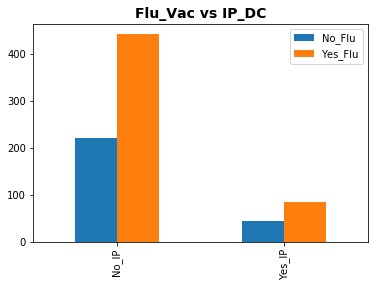

In [18]:
flu_ip.plot(kind="bar")
plt.title("Flu_Vac vs IP_DC", fontweight="bold", fontsize=14)
plt.show()

from mpl_toolkits.mplot3d import axes3d
style.use('ggplot')

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x3 = [1,2,3,4,5,6,7,8,9,10]
y3 = [5,6,7,8,2,5,6,3,7,2]
z3 = np.zeros(10)

dx = np.ones(10)
dy = np.ones(10)
dz = [1,2,3,4,5,6,7,8,9,10]

ax1.bar3d(x3, y3, z3, dx, dy, dz)


ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.set_zlabel('z axis')

plt.show()

In [19]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)


#test_df = pd.read_csv('test_data_for_chi_square.csv')
print(chi_square_of_df_cols(fmh, 'Flu_Vac', 'IP_DC'))

(0.0082724182553183, 0.9275300676036707, 1, array([[220.94563843,  43.05436157],
       [441.05436157,  85.94563843]]))


In [20]:
fmh_copy=fmh[["Flu_Vac", "Pneu_Vac", "Preventive_Care", "IP_DC", "Readmit", "ED_Visit"]]
fmh_copy = fmh_copy.astype(int)
yes = fmh_copy.sum().values
no = (fmh_copy == 0).sum().values
no

array([264, 155, 592, 662, 751, 730])

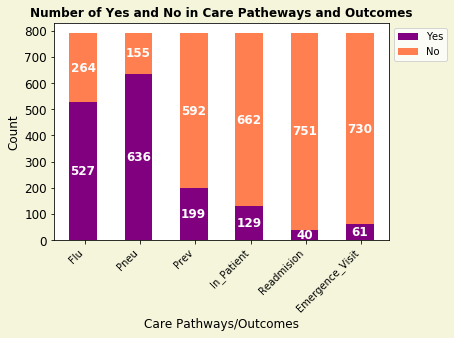

In [21]:
fig = plt.figure(facecolor="beige")

ax = fig.add_subplot(1, 1, 1)
bar_width = 0.5
bar_l = np.arange(1,7)
tick_pos = [i + (bar_width / 16) for i in bar_l]

ax1 = ax.bar(bar_l, yes, width=bar_width, label="Yes", color="purple")
ax2 = ax.bar(bar_l, no, bottom=yes, width=bar_width, label="No", color="coral")
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Care Pathways/Outcomes", fontsize=12)
ax.legend(loc="best", bbox_to_anchor=(1, 1))
#plt.xticks(tick_pos, ["Flu", "Pneu", "Prev", "In_Patient", 
                     # "Readmision", "Emergence_Visit"], rotation=45)
plt.yticks(fontsize=12)
labels=["Flu", "Pneu", "Prev", "In_Patient", "Readmision", "Emergence_Visit"]
ax.set_xticks(tick_pos)
ax.set_xticklabels(labels, rotation = 45, ha="right")

for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, 
             ha="center", va="center", color="white", fontsize=12, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, 
             ha="center", va="center", color="white", fontsize=12, fontweight="bold")

plt.title("Number of Yes and No in Care Patheways and Outcomes", fontsize=12, fontweight="bold")
plt.show()

In [34]:
fmh1 = fmh.sort_values('Flu_Vac', ascending=False)
fmh_by_flu = fmh1[fmh1["Flu_Vac"]==1]
fmh_by_flu = fmh_by_flu.sort_values('Pneu_Vac', ascending=False)
#fmh_by_flu = fmh_by_flu.sort_values('Preventive_Care', ascending=False)
fmh2 = fmh1[fmh1["Flu_Vac"]==0]
fmh_by_pneu = fmh2[fmh2["Pneu_Vac"]==1]
#fmh_by_pneu = fmh_by_pneu.sort_values('Pre', ascending=False)
fmh3 = fmh2[fmh2["Pneu_Vac"]==0]
fmh_by_prev = fmh3[fmh3["Preventive_Care"]==1]
fmh4 = fmh3[fmh3["Preventive_Care"]==0]
fmh_by_ip = fmh4[fmh4["IP_DC"]==True]
fmh5 = fmh4[fmh4["IP_DC"]==False]
fmh_by_re = fmh5[fmh5["Readmit"]==True]
fmh6 = fmh5[fmh5["Readmit"]==False]
fmh_by_em = fmh6[fmh6["ED_Visit"]==True]
fmh_rest = fmh6[fmh6["ED_Visit"]==False]
dfs = [fmh_by_flu, fmh_by_pneu, fmh_by_prev, fmh_by_ip, fmh_by_re, fmh_by_em, fmh_rest]
sorted_fmh = pd.concat(dfs)
sorted_fmh = sorted_fmh[["Flu_Vac", "Pneu_Vac", "Preventive_Care", "IP_DC", "Readmit", "ED_Visit"]]
sorted_fmh = sorted_fmh.astype(int)
sorted_fmh.shape

(791, 6)

In [29]:
test = fmh_by_flu.sort_values('Pneu_Vac', ascending=False)
test

,Flu_Vac,Pneu_Vac,Preventive_Care,IP_DC_Count,Readmit_Count,ED_Visit_Count,IP_DC,Readmit,ED_Visit,No_IP,No_Readmit,No_ED,Has_Bad_Outcome,No_Bad_Outcome
1,1,1,0,1,0,1,True,False,True,False,True,False,True,False
177,1,1,0,0,0,0,False,False,False,True,True,True,False,True
50,1,1,0,0,0,0,False,False,False,True,True,True,False,True
223,1,1,1,0,0,0,False,False,False,True,True,True,False,True
49,1,1,0,2,0,0,True,False,False,False,True,True,True,False
48,1,1,1,0,2,0,False,True,False,True,False,True,True,False
198,1,1,1,0,0,0,False,False,False,True,True,True,False,True
196,1,1,0,0,0,0,False,False,False,True,True,True,False,True
195,1,1,0,0,0,0,False,False,False,True,True,True,False,True
172,1,1,0,1,0,0,True,False,False,False,True,True,True,False


In [ ]:
fmh_rest.shape

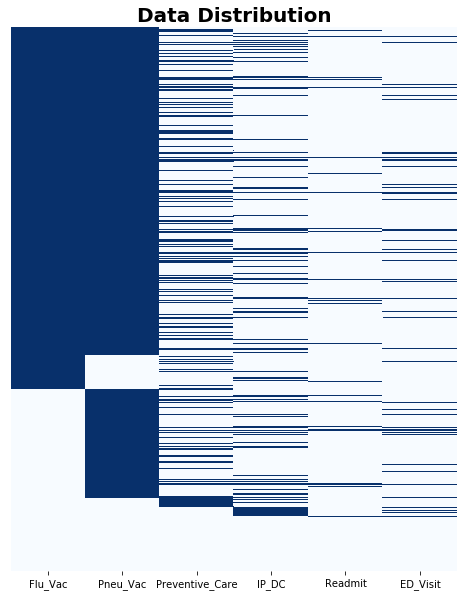

In [35]:
fig = plt.figure(figsize=(8,10))
ax=sns.heatmap(sorted_fmh, xticklabels="auto", yticklabels=False, cbar=False, cmap="Blues")
plt.title("Data Distribution", fontweight="bold", fontsize=20)
#sns.set(font_scale=1.5)
plt.show()

Old Code:

#pick_columns = ['Flu_Vac','Pneu_Vac','Preventive_Care','No_IP','No_Readmit','No_ED',]
fig = plt.figure(figsize=(8,200))
ax=sns.heatmap(fmh[fmh.columns[0:6]], xticklabels=True, yticklabels=True,
               linecolor= "grey", cbar=False, cmap="Blues", vmin=0, 
               vmax=1, linewidths=1)
plt.title("Data Distribution", fontweight="bold", fontsize=20)
ax.hlines(range(fmh[fmh.columns[0:6]].astype(int).shape[0]),*ax.get_xlim(), color="grey")
ax.vlines(range(fmh[fmh.columns[0:6]].astype(int).shape[1]),*ax.get_ylim(), color="grey")
plt.show()

In [ ]:
set1 =set(np.array(fmh[fmh["Flu_Vac"]==True].index))
set2 = set(np.array(fmh[fmh["Pneu_Vac"]==True].index))
set3= set(np.array(fmh[fmh["Preventive_Care"]==True].index))
#set1

In [ ]:
# calcualte the number of no bad outcome for each intersection.
fmh_venn = fmh.astype(int)
no_bad_outcome = fmh_venn[["No_Bad_Outcome"]]

# 1 
just_prev_index = list(set1.union(set2, set3) - set1 - set2)
just_prev = no_bad_outcome.iloc[just_prev_index].sum()[0]

#2
just_pneu_index = list(set1.union(set2, set3) - set3 - set1)
just_pneu = no_bad_outcome.iloc[just_pneu_index].sum()[0]

#3
prev_pneu_index = list(set2.intersection(set3)- set1)
prev_pneu = no_bad_outcome.iloc[prev_pneu_index].sum()[0]

#4
just_flu_index = list(set1.union(set2, set3) - set3 - set2)
just_flu = no_bad_outcome.iloc[just_flu_index].sum()[0]

#5
prev_flu_index = list(set1.intersection(set3)- set2)
prev_flu = no_bad_outcome.iloc[prev_flu_index].sum()[0]

#6
pneu_flu_index = list(set1.intersection(set2)- set3)
pneu_flu = no_bad_outcome.iloc[pneu_flu_index[0:341]].sum()[0]

#7
intersection_index = list(set1.intersection(set2, set3))
intersection = no_bad_outcome.iloc[intersection_index].sum()[0]

no_bad_total =[just_prev, just_pneu, prev_pneu, just_flu, prev_flu, pneu_flu, intersection]

In [ ]:
fig = plt.figure(figsize=(5,5))
fig.add_subplot(1, 1, 1)

v = matplotlib_venn.venn3_unweighted([set1, set2, set3],
      set_labels = ('Flu Vac', "Pneumonia Vac", 'Preventive Care'), alpha = 0.5)
plt.title("Intersection of Care Pathways", fontweight="bold", fontsize=16)

#colors=["red", "pink", "green", "grey", "orange", "purple", "blue"]
colors=["coral", "beige", "pink", "deepskyblue", "red", "lightblue", "blue"]

for i in range(7):
    b = bin(i+1)[2:].zfill(3)
    v.get_patch_by_id(b).set_color(colors[i])
    intersect_text = v.get_label_by_id(b)
    intersect_num = re.findall(r"'(.*?)'", str(intersect_text), re.DOTALL)
    for ele in intersect_num:
        ele1=str(no_bad_total[i])+"/"+ele
        ele2 = str(round((no_bad_total[i]/float(ele))*100, 2))+"%"
        ele=ele1+ "\n" +ele2
        v.get_label_by_id(b).set_text(ele)
        v.get_label_by_id(b).set_size(10)
    
v.get_label_by_id('A').set_size(12)
v.get_label_by_id('B').set_size(12)
v.get_label_by_id('C').set_size(12)

#v.get_label_by_id('001').set_text("12")
plt.text(1.2, 0.5, 
         "Example:78.95% (30 out of 38) patients \nwho took flu shot have good outcomes.\ngood outcome: no inpatient /emergency visiti /readmission")

fig = plt.figure(figsize=(4, 2))
ax3 = fig.add_axes([4, 3, 1, 0.15])
colors=["blue","deepskyblue","lightblue", "beige", "pink", "coral", "red"]

cmap = mpl.colors.ListedColormap(colors)
cmap.set_over((1., 0., 0.))
cmap.set_under((0., 0., 1.))

bounds = [-1.5,-1., -.5, 0., .5, 1.,1.5, 2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax3, cmap=cmap,
                                norm=norm,
                                extendfrac='auto',
                                orientation='horizontal')
cb3.set_ticks([])

cb3.set_label('low                                                                    high \nGood Outcome Rate')

plt.show()

__Interpretation:__<br>
1. __135 patients took all three care pathways. 77.78% of them didn't have COPD recurance__
2. 38 patients only took flu vaccine. 30 out of them (78.95%) didn't have COPD recurance. 
3. 120 patients only took pneumonia vaccine.
4. 13 patients only took preventive care (AWV & TCM_CCM)
5. 342 patients only took flu vaccine and pneumonia vaccine.
6. 12 patients only took flu vaccine and preventive care.
7. 39 patients only took pneumonia vaccine and preventive care.

In [ ]:
fmh.columns

In [ ]:
sns.set(font_scale=1)
correlations = fmh[fmh.columns[0:6]].corr()
f,ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(correlations, annot=True, linewidths=.5, fmt= '.2f',ax=ax1)
ax1.xaxis.tick_top()
ax1.set_xticklabels(fmh[fmh.columns[0:6]].columns, rotation=60)
ax1.set_yticklabels(fmh[fmh.columns[0:6]].columns)
plt.title("Correlation among Variabes", y=1.3, fontweight="bold")
plt.show()

In [ ]:
sns.set(font_scale=1)
correlations = (fmh[['Flu_Vac', 'Pneu_Vac', 'Preventive_Care', 'No_IP', 'No_Readmit', 'No_ED']].astype(int)).corr()
f,ax1 = plt.subplots(figsize=(8, 8))
sns.heatmap(correlations, annot=True, linewidths=.5, fmt= '.2f',ax=ax1)
ax1.xaxis.tick_top()
ax1.set_xticklabels((fmh[['Flu_Vac', 'Pneu_Vac', 'Preventive_Care', 'No_IP', 'No_Readmit', 'No_ED']].astype(int)).columns, 
                    rotation=60)
ax1.set_yticklabels((fmh[['Flu_Vac', 'Pneu_Vac', 'Preventive_Care', 'No_IP', 'No_Readmit', 'No_ED']].astype(int)).columns)
plt.title("Correlation among Variabes", y=1.3, fontweight="bold")
plt.show()

__Interpretation__ <br>
From the heatmap, we can see, the correlation among predictor variables and bad outcome class labels as well as the no bad outcome class labels are not very strong. 

### Regression Model
This project trys to make a regression model to predict the class labels since they are numeric. <br>
The project trys on the in-patient discharge first.

In [ ]:
x =fmh.iloc[:, 0:3].values
y_ip = fmh.iloc[:, 3].values
y_re = fmh.iloc[:, 4].values
y_ed = fmh.iloc[:, 5].values

In [ ]:
x_train, x_test, y_ip_trian, y_ip_test = train_test_split(x, y_ip, random_state=123)

In [ ]:
reg_ip = linear_model.BayesianRidge().fit(x, y_ip)
reg_pre_ip = reg_ip.predict(x_test)
reg_ip_df = pd.DataFrame()
reg_ip_df["True"] = y_ip_test
reg_ip_df["Prediction"] = reg_pre_ip
reg_ip_df.head()

In [ ]:
ax=reg_ip_df.plot()
ax.set_facecolor("beige")
plt.title("Evaluation of the Regression Model for IP", fontweight="bold")
ax.legend(bbox_to_anchor=[1,1])
plt.show()

In [ ]:
rmse_ip = np.sqrt(metrics.mean_squared_error(y_ip_test,reg_pre_ip))
rmse_ip

__Interpretation:__<br>The root mean square error of the regression model is 0.58. Overal the model predicts the trend of the test data set, but the accuracy is not good. The reason why this model is not good enough might be that this class label, although it is numeric, it is not continous, and most of the data is 0. In this case, it may be better to build a classification model.

### Classification Models

In [ ]:
fmh.info()

In [ ]:
# No inpatient, no readmission, no emergency visit
y_ip_cl = fmh.iloc[:, 9].values
y_re_cl = fmh.iloc[:, 10].values
y_ed_cl = fmh.iloc[:, 11].values

In [ ]:
x_ip_cl_train, x_ip_cl_test, y_ip_cl_train, y_ip_cl_test = train_test_split(x, y_ip_cl, random_state=12)
x_re_cl_train, x_re_cl_test, y_re_cl_train, y_re_cl_test = train_test_split(x, y_re_cl, random_state=12)
x_ed_cl_train, x_ed_cl_test, y_ed_cl_train, y_ed_cl_test = train_test_split(x, y_ed_cl, random_state=12)

In [ ]:
clf_ip = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = 3, min_samples_leaf = 2)
clf_ip = clf_ip.fit(x_ip_cl_train,y_ip_cl_train)

clf_re = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = 3, min_samples_leaf = 2)
clf_re = clf_ip.fit(x_re_cl_train,y_re_cl_train)

clf_ed = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100, 
            max_depth = 3, min_samples_leaf = 2)
clf_ed = clf_ip.fit(x_ed_cl_train,y_ed_cl_train)

In [ ]:
graph = Source(tree.export_graphviz(clf_ip, out_file=None, feature_names = ["Flu", "Pneu", "Prev"],
                                    class_names=["False", "True"], filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
graph = Source(tree.export_graphviz(clf_re, out_file=None, feature_names = ["Flu", "Pneu", "Prev"],
                                    class_names=["False", "True"], filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
graph = Source(tree.export_graphviz(clf_ed, out_file=None, feature_names = ["Flu", "Pneu", "Prev"],
                                    class_names=["False", "True"], filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
ip_predict = clf_ip.predict(x_ip_cl_test)
re_predict = clf_re.predict(x_re_cl_test)
ed_predict = clf_ed.predict(x_ed_cl_test)

In [ ]:
cm_ip = confusion_matrix(y_ip_cl_test, ip_predict)
cm_re = confusion_matrix(y_re_cl_test, re_predict)
cm_ed = confusion_matrix(y_ed_cl_test, ed_predict)

In [ ]:
cm_ip_df = pd.DataFrame(cm_ip, columns=["Has In-Patient", "No In-Patient"], index=["Has In-Patient", "No In-Patient"])
cm_re_df = pd.DataFrame(cm_re, columns=["Has In-Patient", "No In-Patient"], index=["Has In-Patient", "No In-Patient"])
cm_ed_df = pd.DataFrame(cm_ed, columns=["Has In-Patient", "No In-Patient"], index=["Has In-Patient", "No In-Patient"])
#cm_ip_df.index.name="Fact"
print(cm_ip_df)
print(cm_re_df)
print(cm_ed_df)

__Interpretation:__ <br>
The classifers don't work well at tall as they fail to capture the bad outcome. It may because the class labels have small amount of "Yes". The data is not balance, so it is hard to make an useful classification model.

# Association Analysis

In [ ]:
fmh_asso = fmh.drop(["IP_DC_Count", "Readmit_Count", "ED_Visit_Count", 'No_IP', 'No_Readmit', 'No_ED', 'Has_Bad_Outcome',
       'No_Bad_Outcome'], axis=1)

In [ ]:
frequent_itemsets = apriori(fmh_asso, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.shape

In [ ]:
def uppack_frozenset(myseries, mylist):
    index_list = []
    items=[]
    for index, value in myseries.iteritems():
        for item in value:
            if (len(value)==1) & (item in mylist):
                index_list.append(index)
            elif item in mylist:
                items.append(index)
        if len(items) == len(value):
            index_list.append(index)
        items=[]
    return index_list

In [ ]:
predictors = ["Preventive_Care", "Flu_Vac", "Pneu_Vac"]               
predictors_index = uppack_frozenset(rules.antecedents, predictors)
class_labels = ["IP_DC", "Readmit", "ED_Visit"]
class_labels_index = uppack_frozenset(rules.consequents, class_labels)
good_index = list(set(predictors_index) & set(class_labels_index))
good_results = rules.iloc[good_index, :].sort_values(by='confidence', ascending=False).reset_index(drop=True)

__Below are rules with the features as "antecedents" and class labels as "consequents".__

In [ ]:
good_results

In [ ]:
fig = plt.figure(facecolor="beige")
plt.scatter(good_results["support"], good_results["confidence"])
plt.xlabel("support")
plt.ylabel("confidence")
plt.title("Support and Confidence", fontdict={'fontweight':"bold"})
plt.show()

In [ ]:
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    #seed=12
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']        
    
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i+1)])
      
        for a in rules.iloc[i, 0]:        
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i+1), color=colors[i] , weight = 2)
       
        for c in rules.iloc[i, 1]:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i+1), c, color=colors[i],  weight=2)
    
    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('grey')
        else:
            color_map.append('coral')       
 
    edges = G1.edges()
    
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
    
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map,edge_color=colors, width=weights, 
            font_size=12, with_labels=False, arrowsize=20) 
    
    for p in pos:  # raise text positions
        pos[p][1] += 0.12
    nx.draw_networkx_labels(G1, pos)
    
    s="   Support  confidence\n"
    for i, val in rules[["support", "confidence"]].iterrows(): 
         s += ("R"+str(i+1)+"   " +str(round(val[0]*100, 2))+"%" + 
                "   "+str(round(val[1]*100, 2))+"%"+"\n")
        
    plt.text(1, 1, s=s)
    plt.show()

In [ ]:
draw_graph(good_results, good_results.shape[0])

__Interpretation__<br>
Rule No.1: It is 28.74% confident that if a patient takes preventive care and pneumonia vaccine, he will only have 6.32% chance to get in-patient. <br>
It may sound better when the concequent is NO in-patient/NO readmission /NO emergency visit. So the project works on it below.

In [ ]:
drop_col = [3, 4, 5, 6, 7, 8]
fmh_asso2 = fmh.drop(['IP_DC_Count','Readmit_Count','ED_Visit_Count','IP_DC','Readmit',
    'ED_Visit', 'Has_Bad_Outcome',
    'No_Bad_Outcome'], axis=1)
fmh_asso2.head()

In [ ]:
frequent_itemsets2 = apriori(fmh_asso2, min_support=0.0001, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2

In [ ]:
predictors_index2 = uppack_frozenset(rules2.antecedents, predictors)
class_labels2 = ["No_IP", "No_Readmit", "No_ED", "No_Bad_Outcome", "Has_Bad_Outcome"]
class_labels_index2 = uppack_frozenset(rules2.consequents, class_labels2)
good_index2 = list(set(predictors_index2) & set(class_labels_index2))
good_results2 = rules2.iloc[good_index2, :].sort_values(by=['support','confidence'], ascending=False).reset_index(drop=True)
good_results2

In [ ]:
fig = plt.figure(facecolor="beige")
plt.scatter(good_results2["support"], good_results2["confidence"])
plt.xlabel("support")
plt.ylabel("confidence")
plt.title("Support and Confidence 2", fontdict={'fontweight':"bold"})
plt.show()

In [ ]:
draw_graph(good_results2, good_results2.shape[0])

__Interpretation:__<br>
Rule No.1: If a patient takes flu vaccine, it is 92.41% confident that he/she has 61.57% chance not going to the emergency room.<br>
Rule No.2: If a patient takes flu vaccine, it is 83.87% confident that he/she has 55.88% chance not getting in-patient.<br>
Rule No.3: If a patient takes flu vaccine, it is 82.16% confident that he/she has 54.74% chance not getting in-patient or readmission.<br>
Rule No.6: If a patient takes flu vaccine and pneunomia vaccine, it is 81.76% confident that he/she has 49.3% chance not getting in-patient or going to emergency room. <br>

In [ ]:
fmh.columns

In [ ]:
#drop_col = [3, 4, 5, 6, 7, 8]
fmh_asso3 = fmh.drop(['IP_DC_Count','Readmit_Count','ED_Visit_Count','IP_DC','Readmit',
    'ED_Visit', u'No_IP', u'No_Readmit', u'No_ED', u'Has_Bad_Outcome'], axis=1)
#fmh_asso3.head()

frequent_itemsets3 = apriori(fmh_asso3, min_support=0.001, use_colnames=True)
rules3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=1)
rules3.head()

In [ ]:
predictors_index3 = uppack_frozenset(rules3.antecedents, predictors)
class_labels3 = ["No_Bad_Outcome"]
class_labels_index3 = uppack_frozenset(rules3.consequents, class_labels3)
good_index3 = list(set(predictors_index3) & set(class_labels_index3))
good_results3 = rules3.iloc[good_index3, :].sort_values(by=['support','confidence'], ascending=False).reset_index(drop=True)
good_results3

__Interpretation__<br>
it is 80% confident that if a patient took flu shot, he/she has 66.62% chance not getting COPD in-patient, readmission or emergency visit. <br>
__The rules shows that taking flu shots prevents COPD recurrence the best.__